In [160]:
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import imageio
from scipy import interpolate
from skimage.filters import gaussian
plt.style.use(['science', 'notebook'])
import tomopy

from scipy.interpolate import RectBivariateSpline
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, rescale, rotate
from skimage.measure import profile_line

# Part 1: Simulation of the Sinogram

In [2]:
A = shepp_logan_phantom()
T = np.asarray(imageio.imread('tumours.png')[:,:,0] > 0)
n = A.shape[0]

In [3]:
T_masked = np.ma.masked_where(~T, T)

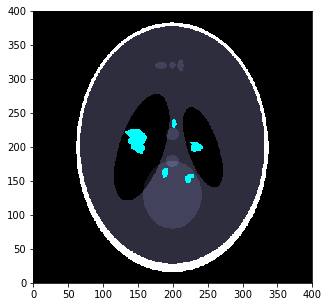

In [4]:
plt.figure(figsize=(5,5))
plt.pcolor(A, cmap='bone')
plt.pcolor(T_masked, cmap='cool')
plt.show()

Text(0, 0.5, 'Attenuation [Normalized]')

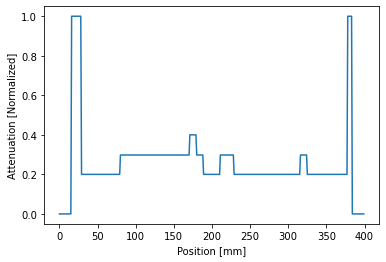

In [5]:
plt.plot(A[:,n//2])
plt.xlabel('Position [mm]')
plt.ylabel('Attenuation [Normalized]')

If probability of attenuation is around 50% then we can find how to adjust $\mu$

$$e^{-\mu x} = p \implies \mu = -\ln(p)/x$$

In [6]:
p = 0.5
mu = -np.log(p)/n

Approximate mean value of the image A:

In [7]:
m = np.mean(A[A>0])
m

0.29344081980773784

This gives the scaling factor:

In [8]:
A = A*mu/m

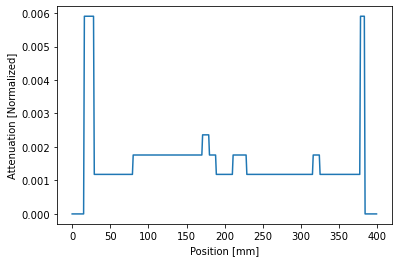

In [9]:
plt.plot(A[:,200])
plt.xlabel('Position [mm]')
plt.ylabel('Attenuation [Normalized]')
plt.show()

The probability of attenuation along this path is

In [10]:
P_sample = np.exp(-np.sum(A[:,200]*1)) #dx = 1mm
P_sample

0.5441386866569932

So about what we want

## The Points That Cause The Decays

Get the indices of the locations where the tumours exist and generate a bunch of random decays. Also get the random angles

In [290]:
U = gaussian(T, sigma=3)
U[~T]=0

In [291]:
decay_values = np.random.poisson(lam=300*U, size=U.shape)
decay_values = decay_values[T]
original = np.zeros(T.shape)
original[T] = decay_values
decay_angles = np.random.uniform(size=decay_values.sum())*2*np.pi

In [292]:
decay_points = np.repeat(np.argwhere(T), decay_values, axis=0)
xs, ys = decay_points.T

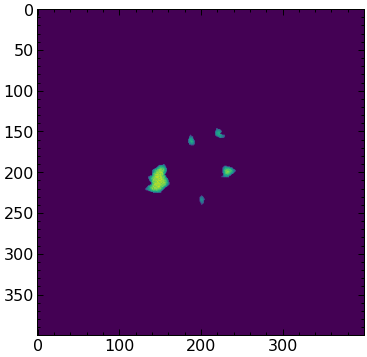

In [293]:
plt.imshow(original)

Show histogram

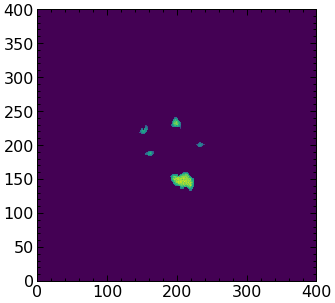

In [295]:
plt.figure(figsize=(5,5))
original, _,_,_ = plt.hist2d(xs, ys, bins=[np.arange(-0.5,n+0.5),np.arange(-0.5,n+0.5)])
plt.xlim(0,n)
plt.ylim(0,n)
plt.show()

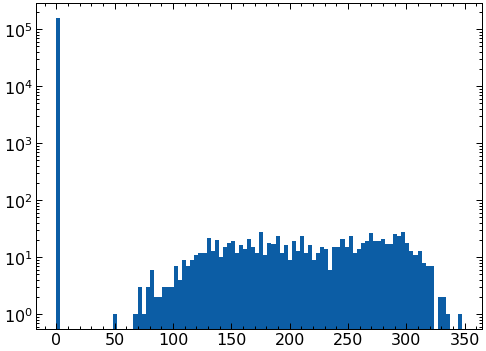

In [296]:
plt.hist(original.ravel(), bins=100)
plt.semilogy()
plt.show()

Using the decay angle and the decay point, we need to compute the line integral passing through **CT IMAGE** to simulate attenuation

(i) Interpolate the 2D attenuation (CT) data

In [297]:
X, Y = np.meshgrid(np.arange(0,400),np.arange(0,400))
XY = np.stack([X.ravel(), Y.ravel()]).T
A_inter = RectBivariateSpline(np.arange(0,400), np.arange(0,400), A)

(ii) Find points on line for each of the points (depends on the decay angle)

In [298]:
diameter = np.sqrt(2*n**2)
x1 = decay_points[6][0] - np.cos(decay_angles[6])* diameter
x2 =  decay_points[6][0] + np.cos(decay_angles[6])* diameter
y1 = decay_points[6][1] - np.sin(decay_angles[6])* diameter
y2 =  decay_points[6][1] + np.sin(decay_angles[6])* diameter

In [299]:
l = profile_line(A, (x1, y1), (x2, y2), mode='constant')

The integral is thus

In [300]:
np.exp(-l.sum())

0.6892297968586879

To do this faster

In [301]:
num = 1000
xmin = min([x1, x2])
xmax = max([x1, x2])
ymin = min([y1, y2])
ymax = max([y1, y2])
xx = np.linspace(xmin, xmax, num)
yy = np.linspace(ymin, ymax, num)
mask = (xx>0) * (xx<n) * (yy>0) * (yy<n)
xx = xx[mask].astype(int)
yy = yy[mask].astype(int)
dL = 2*diameter / num

In [302]:
np.exp(-A[xx,yy].sum()*dL)

0.6593096935684187

Example of this line

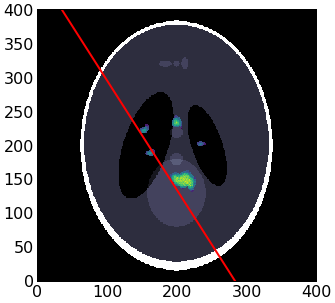

In [303]:
plt.figure(figsize=(5,5))
plt.pcolor(A, cmap='bone')
plt.hist2d(xs, ys, bins=[np.arange(0,n),np.arange(0,n)],
          cmin=1)
plt.plot([x1,x2],[y1,y2], color='r')
plt.xlim(0,n)
plt.ylim(0,n)
plt.show()

In [304]:
def compute_prob_of_detections(decay_points, decay_angles, num=1000):
    diameter = np.sqrt(2*n**2)
    prob_of_detections = []
    for i, (dp, da) in enumerate(zip(decay_points, decay_angles)):
        # Get initial and final points
        x1 = dp[0] - np.cos(da)* diameter
        x2 =  dp[0] + np.cos(da)* diameter
        y1 = dp[1] - np.sin(da)* diameter
        y2 =  dp[1] + np.sin(da)* diameter
        xx = np.linspace(x1, x2, num)
        yy = np.linspace(y1, y2, num)
        mask = (xx>0) * (xx<n) * (yy>0) * (yy<n)
        xx = xx[mask].astype(int)
        yy = yy[mask].astype(int)
        dL = 2*diameter / num
        prob_of_detections.append(np.exp(-A[xx,yy].sum()*dL))
    return np.array(prob_of_detections)

In [305]:
prob_of_detections = compute_prob_of_detections(decay_points, decay_angles)

Can look at a histogram of the probability of detection for eimtted photons.

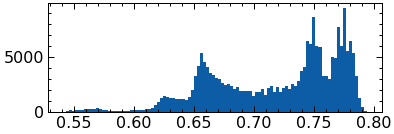

In [306]:
plt.figure(figsize=(6,2))
plt.hist(prob_of_detections, bins=100)
plt.show()

And now we filter all the decay events by this probability of detections. This is attenuation correction

In [307]:
mask = prob_of_detections > np.random.uniform(size=decay_values.sum())

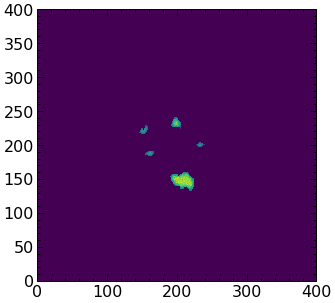

In [308]:
plt.figure(figsize=(5,5))
attenuated,_,_,_=plt.hist2d(xs[mask], ys[mask], bins=[np.arange(-0.5,n+0.5),np.arange(-0.5,n+0.5)])
plt.xlim(0,n)
plt.ylim(0,n)
plt.show()

The bottom tumour (which is in a more highly attenuated region) shows up less on on the scan than the other tumours, despite it being the same activity.

Now we can compute the sinogram

In [309]:
center = (n//2, n//2)

In [310]:
# Not Attenuated
rs_all = (xs - center[0]) * np.cos(decay_angles+np.pi/2) + (ys - center[1]) * np.sin(decay_angles+np.pi/2)
thetas_all = decay_angles
# Attenuated
rs_all_att = (xs[mask] - center[0]) * np.cos(decay_angles[mask]+np.pi/2) + \
             (ys[mask] - center[1]) * np.sin(decay_angles[mask]+np.pi/2)
thetas_all_att = decay_angles[mask]

Not attenuated


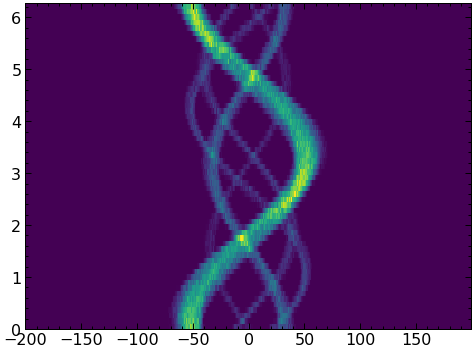

In [311]:
rs_bins = np.arange(-200.5, 200.5, 1)
theta_bins = np.linspace(0,2*np.pi,60)
sino,_,_,_ = plt.hist2d(rs_all,thetas_all,
                            bins=[rs_bins, theta_bins])
plt.show()

Attenuated

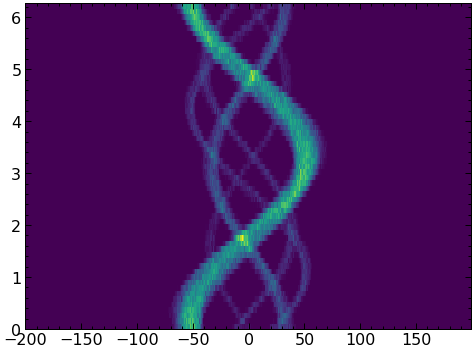

In [312]:
sino_att,_,_,_ = plt.hist2d(rs_all_att,thetas_all_att,
                            bins=[rs_bins,theta_bins])
plt.show()

# Reconstruction

**Step 1**: Attenuation correction matrix. This function takes a coordinate $(x,y)$ and returns the probability that a decay from that point is detected. This assumes isotropic decay in $\theta$ and takes into account different values of $\theta$ to determine this

In [313]:
def compute_prob_of_detections(x, y, thetas = np.linspace(0,np.pi,40), num=1000):
    diameter = np.sqrt(2*n**2)
    prob_of_detections = []
    for theta in thetas:
        # Get initial and final points
        x1 = x - np.cos(theta)* diameter
        x2 =  x + np.cos(theta)* diameter
        y1 = y - np.sin(theta)* diameter
        y2 =  y + np.sin(theta)* diameter
        xx = np.linspace(x1, x2, num)
        yy = np.linspace(y1, y2, num)
        mask = (xx>0) * (xx<n) * (yy>0) * (yy<n)
        xx = xx[mask].astype(int)
        yy = yy[mask].astype(int)
        dL = 2*diameter / num
        prob_of_detections.append(np.exp(-A[xx,yy].sum()*dL))
    return np.mean(prob_of_detections)

Compute $psa$, a 400x400 matrix that gives the probability of being detected given an isotropic decay in $\theta$ at that point

In [314]:
xv, yv = np.meshgrid(np.arange(0,400,4), np.arange(0,400,4))
ps = np.vectorize(compute_prob_of_detections)(xv, yv)
ps_inter = RectBivariateSpline(np.arange(0,400,4), np.arange(0,400,4), ps)
xv, yv = np.meshgrid(np.arange(0,400,1), np.arange(0,400,1))
psa = np.vectorize(ps_inter)(xv,yv)

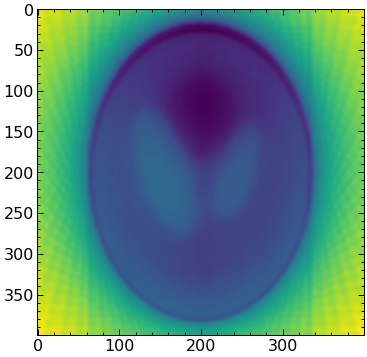

In [315]:
plt.imshow(psa)

**Step 2**: Comparing various algorithms.

First we compute the sinogram of the attenuated data

In [316]:
proj = np.expand_dims(sino_att.T, axis=1)
theta = (theta_bins[:-1]+np.diff(theta_bins)[0]/2)

Reconstruct the PET using MLEM algorithm

In [317]:
im = tomopy.recon(proj, theta, algorithm='mlem', num_iter=20)
im_norm = im[0]*len(theta)

Reconstructing 1 slice groups with 1 master threads...


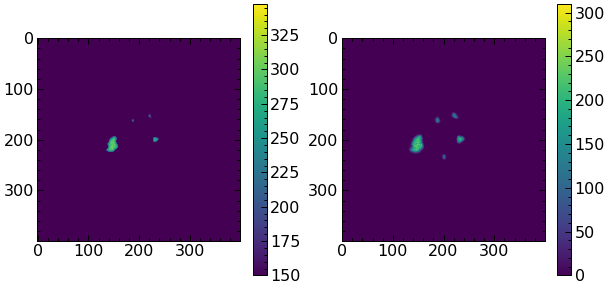

In [318]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
img = ax[0].imshow(original, vmin=150)
plt.colorbar(img, ax=ax[0])
img = ax[1].imshow(im_norm)
plt.colorbar(img, ax=ax[1])
plt.show()

In [319]:
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

In [320]:
mse(original, im[0]*len(theta))

47.99529316359905

In [321]:
errs = []
for i in range(20):
    im = tomopy.recon(proj, theta, algorithm='mlem', num_iter=i)
    errs.append(mse(original, len(theta)*im[0]))

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstruc

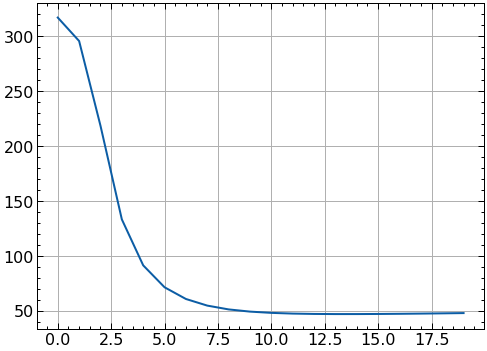

In [322]:
plt.plot(errs)
plt.grid()

Correct the image using the probability matrix

In [323]:
im_corr = im_norm / psa

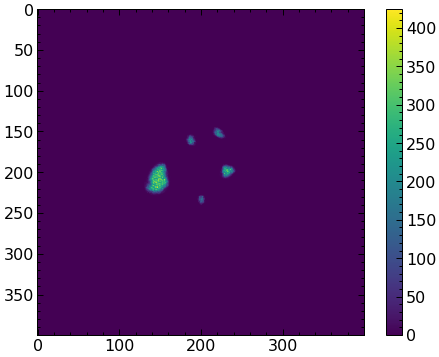

In [324]:
plt.imshow(im_corr)
plt.colorbar()

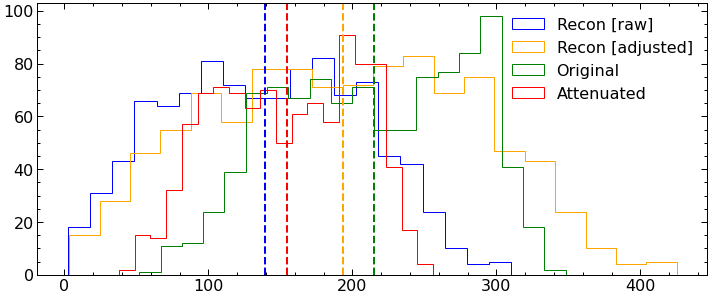

In [325]:
plt.figure(figsize=(12,5))
plt.hist(im_norm[original>0].ravel(), color='blue', histtype='step', bins=20, label='Recon [raw]')
plt.axvline(im_norm[original>0].mean(), color='blue', ls='--')
plt.hist(im_corr[original>0].ravel(), color='orange', histtype='step', bins=20, label='Recon [adjusted]')
plt.axvline(im_corr[original>0].mean(), color='orange', ls='--')
plt.hist(original[original>0].ravel(), color='green', histtype='step', bins=20, label='Original')
plt.axvline(original[original>0].mean(), color='green', ls='--')
plt.hist(attenuated[original>0].ravel(), color='red',  histtype='step', bins=20, label='Attenuated')
plt.axvline(attenuated[original>0].mean(), color='red', ls='--')
plt.legend()
plt.show()

In [326]:
np.mean(attenuated)

0.97463125

In [327]:
np.mean(im_norm)

0.9747093

In [328]:
np.mean(original)

1.3541375

In [329]:
np.mean(im_corr)

1.3573058657328623

# Trial of Many Algorithms

In [330]:
im = tomopy.recon(proj, theta, algorithm='mlem', num_iter=40)
im_norm = im[0]*len(theta)
im_corr = im_norm / psa

Reconstructing 1 slice groups with 1 master threads...


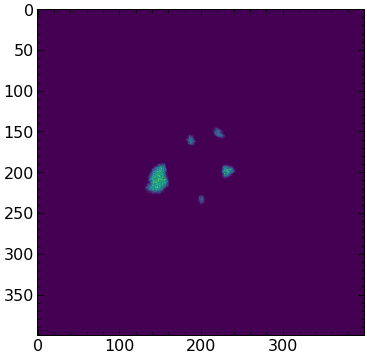

In [331]:
plt.imshow(im_corr)

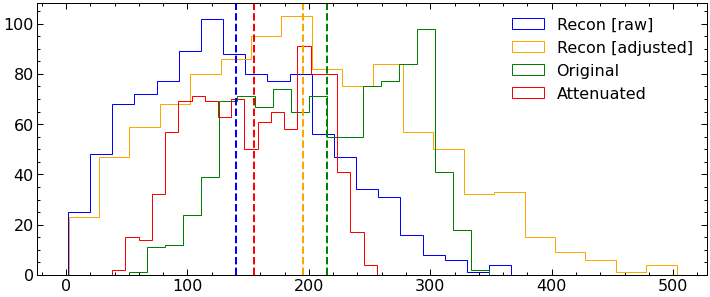

In [332]:
plt.figure(figsize=(12,5))
plt.hist(im_norm[original>0].ravel(), color='blue', histtype='step', bins=20, label='Recon [raw]')
plt.axvline(im_norm[original>0].mean(), color='blue', ls='--')
plt.hist(im_corr[original>0].ravel(), color='orange', histtype='step', bins=20, label='Recon [adjusted]')
plt.axvline(im_corr[original>0].mean(), color='orange', ls='--')
plt.hist(original[original>0].ravel(), color='green', histtype='step', bins=20, label='Original')
plt.axvline(original[original>0].mean(), color='green', ls='--')
plt.hist(attenuated[original>0].ravel(), color='red',  histtype='step', bins=20, label='Attenuated')
plt.axvline(attenuated[original>0].mean(), color='red', ls='--')
plt.legend()
plt.show()

In [349]:
im_corr_corr = gaussian(im_corr, sigma=0.9)

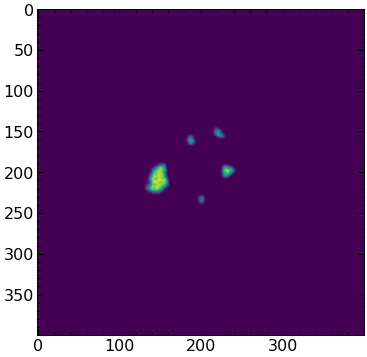

In [350]:
plt.imshow(im_corr_corr)

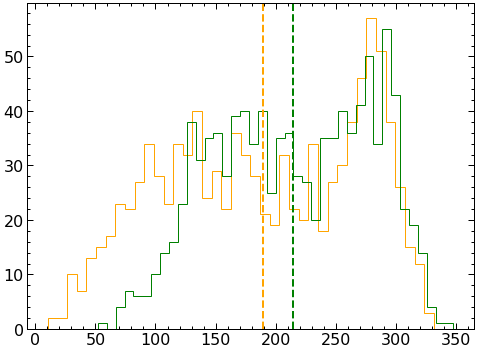

In [335]:
plt.hist(im_corr_corr[original>0].ravel(), color='orange', histtype='step', bins=40, label='Recon [adjusted]')
plt.axvline(im_corr_corr[original>0].mean(), color='orange', ls='--')
plt.hist(original[original>0].ravel(), color='green', histtype='step', bins=40, label='Original')
plt.axvline(original[original>0].mean(), color='green', ls='--')

In [339]:
np.mean(U[T>0]*300)

214.20922842583798

In [340]:
np.std(U[T>0]*300)

62.34318704101366

In [344]:
# When tumour lambda is constant
SUV_max_theory = gammaincinv(300, 0.5**(1/T.sum())) - 1
# When not:
maxes = []
for i in range(10000):
    dv = np.random.poisson(lam=300*U, size=U.shape)
    dv = dv[T]
    B = np.zeros(T.shape)
    B[T] = dv
    maxes.append(B.max())
SUV_max_theory = np.mean(maxes)

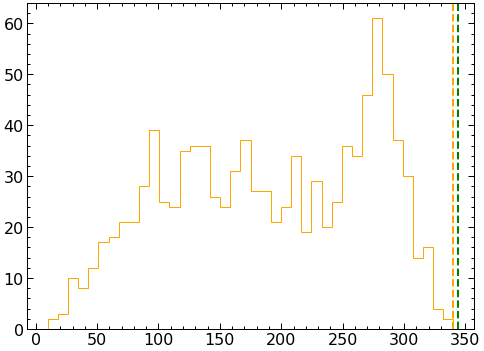

In [351]:
plt.hist(im_corr_corr[original>0].ravel(), color='orange', histtype='step', bins=40, label='Recon [adjusted]')
plt.axvline(im_corr_corr[original>0].max(), color='orange', ls='--')
plt.axvline(SUV_max_theory, color='green', ls='--')

# Poisson ORder Stat Stuff

In [209]:
from scipy.special import gammaincinv

In [234]:
poiss = np.random.poisson(lam=300, size=(1000,100))

In [235]:
poiss.max(axis=1).shape

(1000,)

In [236]:
np.percentile(poiss.max(axis=1), 50)

344.0

In [237]:
gammaincinv(300, 0.5**(1/100))

344.3267059327174

In [251]:
gammaincinv(300, 0.5**(1/T.sum())) - 1

357.52412568840293

In [253]:
maxes = []
for i in range(10000):
    dv = np.random.poisson(lam=300, size=T.sum())
    B = np.zeros((n,n))
    B[T] = dv
    maxes.append(B.max())

In [254]:
np.percentile(maxes, 50)

357.0

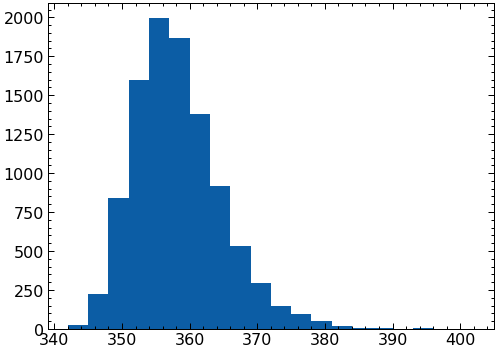

In [257]:
plt.hist(maxes, bins=20)
plt.show()

In [255]:
np.mean(maxes)

357.7782

# Early Stuff

In [619]:
thes = (theta_bins[:-1]+np.diff(theta_bins)[0]/2)*360/(2*np.pi)
n_thes = len(thes)

In [620]:
sino_og = sino*n_thes
sino_att = sino_att*n_thes
sino_radon = radon(original, theta=thes)

C:\Users\lukep\anaconda3\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])


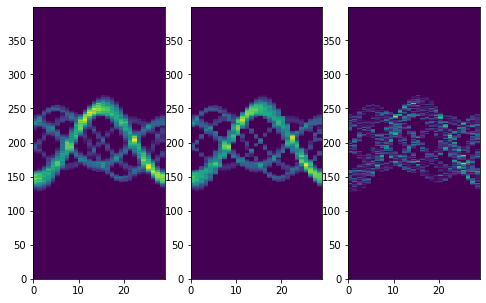

In [621]:
fig, ax = plt.subplots(1, 3, figsize = (8,5))
ax[0].pcolor(sino_og)
ax[1].pcolor(sino_radon)
ax[2].pcolor(np.abs(sino_og - sino_radon))
plt.show()

In [622]:
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

In [629]:
n_iter = 200
estimate, err, sums, means = mlem(sino_og, n_iter, original, thes)
#estimate, err, sums, means = mlem(radon(original, theta=thes), n_iter, original, thes)

C:\Users\lukep\anaconda3\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\lukep\anaconda3\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


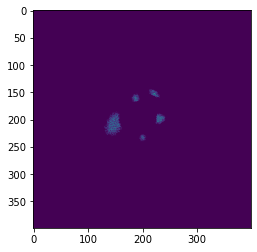

In [630]:
plt.imshow(estimate)

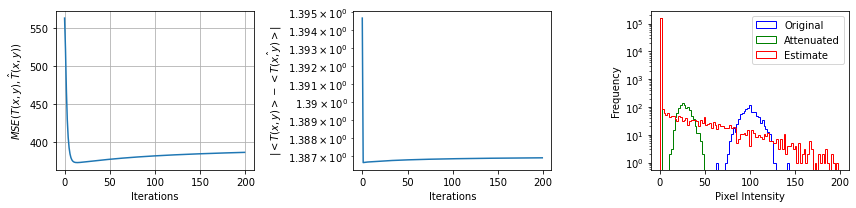

In [633]:
fig, ax = plt.subplots(1,3,figsize=(12,3))
ax[0].plot(np.arange(0,len(err),1),err)
ax[0].set_ylabel(r'$MSE(T(x,y), \hat{T}(x,y))$')
ax[0].set_xlabel(r'Iterations')
ax[0].grid()
ax[1].plot(np.arange(0,len(means),1),means)
ax[1].set_ylabel(r'$|<T(x,y)>-<\hat{T(x,y)}>|$')
ax[1].set_xlabel(r'Iterations')
ax[1].set_xlabel(r'Iterations')
ax[1].semilogy()
ax[2].hist(og.ravel(), bins=np.linspace(0,200,100), histtype='step', color='blue', label='Original')
ax[2].hist(att.ravel(), bins=np.linspace(0,200,100), histtype='step', color='green', label='Attenuated')
ax[2].hist(estimate.ravel(), bins=np.linspace(0,200,100), histtype='step', color='red', label='Estimate')
ax[2].legend()
ax[2].set_xlabel('Pixel Intensity')
ax[2].set_ylabel('Frequency')
ax[2].semilogy()
fig.tight_layout()
plt.show()

In [613]:
def mlem(measured_sino,n_it,original,proj_angles,plotting=False):
    sino_ones = np.ones(measured_sino.shape)
    backproj_of_ones = iradon(sino_ones, proj_angles, filter_name=None)
    for i in range(1,n_it+1):
        if i == 1:
            estimate = np.ones(original.shape)*100
            mserr = []
            sums = []
            means = []
        forward_estimate = radon(estimate, theta=proj_angles, preserve_range=True)
        ratio = np.divide(measured_sino, forward_estimate, out=np.zeros_like(measured_sino), where=forward_estimate!=0)
        backproj = iradon(ratio, proj_angles, filter_name=None)
        estimate = estimate*backproj
        estimate = np.divide(estimate, backproj_of_ones, out=np.zeros_like(estimate), where=backproj_of_ones!=0)
        mserr.append(mse(original,estimate))
        means.append(np.abs(np.mean(original)-np.mean(estimate)))
        sums.append(np.abs(np.sum(estimate[estimate>0]) - np.abs(np.sum(original[original>0]))))
        
    return estimate, mserr, sums, means

In [116]:
def osem(measured_sino,n_it,original,proj_angles,subsets):
    s_ind = 0
    
    # start the loop to iterate
    for i in range(1,n_it+1):
        
        if i == 1:
            estimate = np.ones(original.shape)
            mserr = []

        for s in subsets.values():
            indices = np.in1d(proj_angles,s) 
            sampled_sino = sino[:,indices]            
            forward_estimate = radon(estimate, theta=s, preserve_range=True)
            ratio = np.divide(sampled_sino, forward_estimate, out=np.zeros_like(sampled_sino), where=forward_estimate!=0)
            backproj = iradon(ratio,theta=s,filter_name=None)
            sino_ones = np.ones(measured_sino.shape)
            backproj_of_ones = iradon(sino_ones[:,indices],filter_name=None)
            estimate = estimate*backproj
            estimate = np.divide(estimate, backproj_of_ones, out=np.zeros_like(estimate), where=backproj_of_ones!=0)
            s_ind+=1      
        mserr.append(mse(original,estimate))

    return mserr